In [5]:
# Import required packages
import requests
import os 
import numpy as np
import pandas as pd
import re
import seaborn as sns
import numpy as np
from collections import Counter
from math import nan
from matplotlib import pyplot as plt
from statsmodels import api as sm
from sys import exit, stderr
from scipy.stats import linregress
import scipy 
import scipy.stats as stats

# Step One: Getting the Bike Station Data

In [2]:
# Query the City Bikes API and retrieve the JSON format data

URL = 'http://api.citybik.es/v2/networks'
response = requests.get(URL)
res_json = response.json()

In [3]:
# Look at format of all US city names

sorted([ x['location']['city'] for x in res_json['networks'] if x['location']['country']=='US'])
# sorted([ x['location']['city'] for x in res_json['networks'] if x['location']['country']=='US'],key=len) # Sorted by name length
# sorted([ x['location']['city'] for x in res_json['networks'] if x['location']['country']=='US'],reverse=True) # Sorted alphabetically but in reverse order

['Ann Arbor, MI',
 'Aspen, CO',
 'Atlanta, GA',
 'Austin, TX',
 'Boise, ID',
 'Boston, MA',
 'Boulder, CO',
 'Buffalo, NY',
 'Charlotte, NC',
 'Chattanooga, TN',
 'Chicago, IL',
 'Cincinnati, OH',
 'Columbus, OH',
 'Dayton, OH',
 'Denver, CO',
 'Des Moines, IA',
 'El Paso, TX',
 'Fargo, ND',
 'Fort Lauderdale, FL',
 'Fort Worth, TX',
 'Greenville, SC',
 'Houston, TX',
 'Indianapolis, IN',
 'Kansas City, MO',
 'Ketchum / Sun Valley, ID',
 'Las Vegas, NV',
 'Long Beach, NY',
 'Los Angeles, CA',
 'Madison, WI',
 'Miami Beach, FL',
 'Milwaukee, WI',
 'Minneapolis, MN',
 'New York, NY',
 'Oklahoma, OK',
 'Omaha, NE',
 'Orlando, FL',
 'Philadelphia, PA',
 'Phoenix, AZ',
 'Pittsburgh',
 'Portland, OR',
 'Salt Lake City',
 'San Antonio, TX',
 'San Diego, CA',
 'San Francisco Bay Area, CA',
 'San Ramon, CA',
 'Santa Monica, CA',
 'Spartanburg, SC',
 'Tampa, FL',
 'Topeka, KS',
 'University of South Florida, FL',
 'University of Virginia, VA',
 'Washington, DC']

In [4]:
# Look at the network info for San Francisco Bay Area

[ x for x in res_json['networks'] if x['location']['city'] == 'San Francisco Bay Area, CA']

[{'company': ['Motivate LLC'],
  'gbfs_href': 'https://gbfs.baywheels.com/gbfs/gbfs.json',
  'href': '/v2/networks/bay-wheels',
  'id': 'bay-wheels',
  'location': {'city': 'San Francisco Bay Area, CA',
   'country': 'US',
   'latitude': 37.7141454,
   'longitude': -122.25},
  'name': 'Bay Wheels'}]

In [5]:
# At this point I opened the https://gbfs.baywheels.com/gbfs/gbfs.json URL in a browser and identified the json
# URLs leading to station information and status json files, and proceeded to request data from those

# Get the list of dicts for every station from the info and status json files
SF_station_info = requests.get('https://gbfs.baywheels.com/gbfs/en/station_information.json').json()['data']['stations']
SF_station_status = requests.get('https://gbfs.baywheels.com/gbfs/en/station_status.json').json()['data']['stations']

# Convert the lists of dicts to dicts with station IDs as keys
SF_station_info = { x['station_id']:(x['lat'],x['lon']) for x in SF_station_info }
SF_station_status = { x['station_id']:(x['num_bikes_available'],x['num_docks_available']) for x in SF_station_status }

In [6]:
# Set up empty lists to take all relevant info that will be loaded into the data frame
all_ids, all_lats, all_lons, all_nbikes, all_ndocks = [], [], [], [], []

# Loop over station data in both SF station dicts to populate the four lists
for station_id,(lat,lon) in SF_station_info.items():
    nbikes,ndocks = SF_station_status[station_id]
    all_ids.append(station_id)
    all_lats.append(lat)
    all_lons.append(lon)
    all_nbikes.append(nbikes)
    all_ndocks.append(ndocks)
    

# Make a dataframe with these four lists as columns
bikes_dataframe = pd.DataFrame.from_dict({ 'StationID':all_ids, 'Latitude':all_lats, 
                                          'Longitude':all_lons, 'BikesAvailable':all_nbikes, 
                                          'DocksAvailable':all_ndocks })

In [7]:
# Calculate some additional information and add it in new columns, and inspect the data frame
bikes_dataframe['Total_Docks'] = bikes_dataframe.BikesAvailable + bikes_dataframe.DocksAvailable
bikes_dataframe['Station_Occupancy'] = round(bikes_dataframe.BikesAvailable / bikes_dataframe.Total_Docks, 3) * 100
bikes_dataframe = bikes_dataframe[bikes_dataframe.Total_Docks > 0] # Filter out stations with zero docks
bikes_dataframe

,StationID,Latitude,Longitude,BikesAvailable,DocksAvailable,Total_Docks,Station_Occupancy
0,46b4ef45-b06b-40eb-9fdf-9bc8ff104a4f,37.323678,-121.874119,2,13,15,13.3
1,7d59176c-49dd-4b07-a5ab-bcc109974db3,37.360001,-121.878778,7,12,19,36.8
2,c53990d7-f965-40f4-b305-3435e1c95a71,37.345759,-121.870678,10,9,19,52.6
3,ed707a89-a68d-4921-a4cb-16c268e45a5b,37.337122,-121.883215,17,5,22,77.3
4,d75591d7-080d-46cb-8ada-0fbe6af676fc,37.336775,-121.909149,21,2,23,91.3
...,...,...,...,...,...,...,...
496,dd3ef1c7-d691-4b1f-a2d2-a9b04363ad49,37.769010,-122.422248,13,4,17,76.5
497,cf1d4581-61da-4ade-97d5-2f856cdb0aad,37.775232,-122.224498,7,8,15,46.7
498,2b140c2a-c038-4983-9290-d801db8a13f5,37.777547,-122.433274,0,21,21,0.0
499,f3db9065-9d34-451e-ae8e-930612f8b8d7,37.826286,-122.265100,0,19,19,0.0


In [15]:
# Save the bike station data to CSV
bikes_dataframe.to_csv('../FinalData/BikeStationData.csv',index=False)

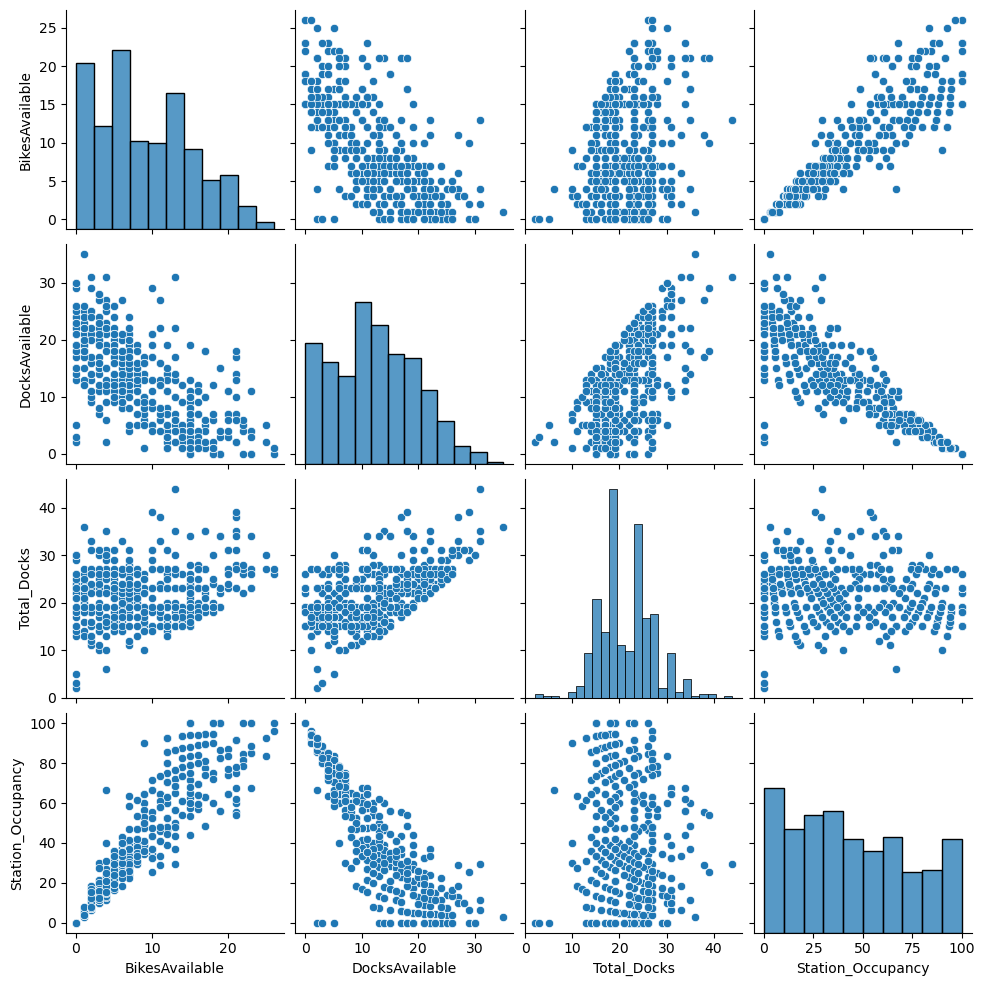

In [3]:
# Lets see if there appears to be linear correlations between BikesAvailable, DocksAvailable, Total_Docks, Station_Occupancy
# Create 4^2 pair plots to investigate all pairs of variables
BikeStationData = pd.read_csv('../FinalData/BikeStationData.csv')
sns.pairplot(data=BikeStationData[['BikesAvailable', 'DocksAvailable', 'Total_Docks', 'Station_Occupancy']])
plt.show()

There doesn't appear to be a correlation between Station_Occupancy and Total_Docks, i.e. stations where more docks are occupied by bikes does not correspond necessarily with a larger overall bike station size. This may be a problem of efficiency, if a large bike station has a large number of occupied bike docks (why aren't many bikes being borrowed?). It would also be a problem when a small bike station has too few bikes available (why aren't there enough bikes available at the station?).

Negative correlation between docks available and bikes available, i.e. if less bikes are available then more empty docks tend to be at a station.

Positive correlation between total docks and bikes available, i.e. larger bike stations tend to have more bikes available in its docks.

In [10]:
# This table shows that Station_Occupancy and Total_Docks have a small |r|
# Likewise for BikesAvailable and Total_Docks
# Small |r| for Total_Docks and DocksAvailable and BikesAvailable and DocksAvailable 
# The small |r| values represent weak linear relationships between the variables
BikeStationData.corr()

,Latitude,Longitude,BikesAvailable,DocksAvailable,Total_Docks,Station_Occupancy
Latitude,1.000000,-0.864740,-0.139359,0.150017,0.044410,-0.143518
Longitude,-0.864740,1.000000,0.143636,-0.184723,-0.085662,0.168190
BikesAvailable,-0.139359,0.143636,1.000000,-0.675486,0.212694,0.899497
DocksAvailable,0.150017,-0.184723,-0.675486,1.000000,0.576829,-0.868918
Total_Docks,0.044410,-0.085662,0.212694,0.576829,1.000000,-0.154967
Station_Occupancy,-0.143518,0.168190,0.899497,-0.868918,-0.154967,1.000000


In [14]:
# Check if any of the correlations are significant using Pearson's test
# The small p-values for the weak correlations suggest that the relationships between the variables are statistically significant even though they are weak.
stat, p1 = scipy.stats.pearsonr(BikeStationData['BikesAvailable'], BikeStationData['DocksAvailable'])
stat, p2 = scipy.stats.pearsonr(BikeStationData['BikesAvailable'], BikeStationData['Station_Occupancy'])
stat, p3 = scipy.stats.pearsonr(BikeStationData['DocksAvailable'], BikeStationData['Station_Occupancy'])
stat, p4 = scipy.stats.pearsonr(BikeStationData['DocksAvailable'], BikeStationData['Total_Docks'])
stat, p5 = scipy.stats.pearsonr(BikeStationData['BikesAvailable'], BikeStationData['Total_Docks'])
stat, p6 = scipy.stats.pearsonr(BikeStationData['Station_Occupancy'], BikeStationData['DocksAvailable'])

print(p1, p2, p3, p4, p5, p6)


9.192039870481123e-68 7.623717811465374e-181 6.516415405018138e-154 1.3472112178545176e-45 1.6326383082041837e-06 6.516415405018138e-154


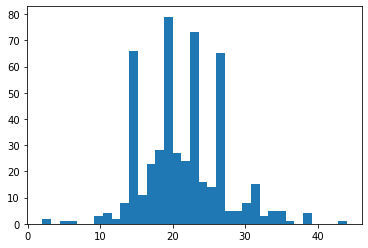

In [9]:
# Create a histogam of the total docks at bike stations to see the range and distribution
plt.hist(bikes_dataframe.Total_Docks,bins=35)
plt.show()

In [10]:
# What are the 25th, 50th, and 75th percentiles of the bike station size?
# It looks likes stations with 80 or less bikes belong to the 25th percentile  
# Stations with bikes in the range (18,21] belong to the 50th percentile
# Stations with bikes in the range (21,75] belong to the 75th percentile
# Stations with bikes in the range (75,100] belong to the 100th percentile 
BSD = BikeStationData.Total_Docks
BSD_percentiles = np.percentile(BSD, [25, 50, 75])
print(BSD_percentiles)

[18. 21. 25.]


In [11]:
# Investigate which bike stations belong to each percentile (25%, 50%, 75%, 100%)
Total_Docks = BikeStationData['Total_Docks'].astype(float)
percentiles = np.percentile(Total_Docks, [25, 50, 75, 100])

bins = [0, percentiles[0], percentiles[1], percentiles[2], percentiles[3]]
bins_labels = ['25%', '50%', '75%', '100%']

BikeStationDataPercentiles = BikeStationData.copy()
BikeStationDataPercentiles['Total_Docks_Percentile'] = pd.cut(Total_Docks, bins, labels=bins_labels, right=False)

print(BikeStationDataPercentiles)

                                StationID   Latitude   Longitude  \
0    0d730ac1-7ce6-45cf-aca6-b412ea46709d  37.350964 -121.902016   
1    d75591d7-080d-46cb-8ada-0fbe6af676fc  37.336775 -121.909149   
2    0d48fc9e-6798-46f0-bbb6-67a168800e0b  37.342997 -121.888889   
3    ab8cc22e-0f34-4476-bf81-293cbbb2e69c  37.360854 -121.906834   
4    68c89d1f-407a-4550-a2b7-ecf0ad7ee422  37.323345 -121.913497   
..                                    ...        ...         ...   
494  ba6302c6-3960-48c0-99c7-27936e2d1275  37.750167 -122.386542   
495  3ccf483a-ed9f-4327-bf9b-d72b4170ebfc  37.763015 -122.426497   
496  9fae2998-e458-47f8-9c7c-978e01f05330  37.787332 -122.388110   
497  d533df76-e03c-4ef3-b928-968aaed45823  37.775946 -122.437777   
498  e6e22821-4578-4bae-94d8-b1dabf0cd0cd  37.730079 -122.398804   

     BikesAvailable  DocksAvailable  Total_Docks  Station_Occupancy  \
0                13              14           27               48.1   
1                21               2      

In [12]:
# Save the percentile data to CSV
BikeStationDataPercentiles.to_csv('../FinalData/BikeStationDataPercentiles.csv', index=False)

It could be interesting to investigate how bike station size is related to other variables, and map out bike station locations in San Francisco while showing their percentiles in terms of station size.

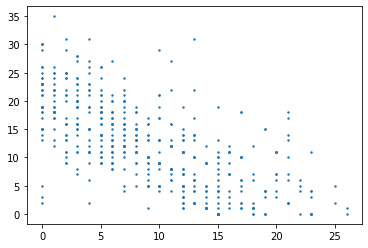

In [13]:
# See if there might be a correlation between bikes available and total docks available at a given station
plt.scatter(bikes_dataframe.BikesAvailable,bikes_dataframe.DocksAvailable,s=2)
plt.show()

In [4]:
# Run a linear regression on this data, where the independent variable is the total number of docks (ie. size of bike station) and the dependent variable is the number of available bikes.
x = BikeStationData["DocksAvailable"]
y = BikeStationData["BikesAvailable"]
x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         BikesAvailable   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     417.1
Date:                Sat, 28 Jan 2023   Prob (F-statistic):           9.19e-68
Time:                        12:08:46   Log-Likelihood:                -1472.5
No. Observations:                 499   AIC:                             2949.
Df Residuals:                     497   BIC:                             2957.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.0232      0.397     40.

The dependent variable is BikesAvailable and the R-squared value is 0.456, which indicates that 45.6% of the variation in the dependent variable is explained by the independent variable(s) in the model. 
The F-statistic of 417.1 and the associated p-value of 9.19e-68 suggest that the model is significant.
The independent variable, 'DocksAvailable, has a coefficient of -0.5647. 
The Omnibus test and Jarque-Bera test suggest that the residuals are not normally distributed. 
The Durbin-Watson statistic of 1.873 suggests that there is some positive autocorrelation in the residuals. 
The condition number of 27.6 indicates that the matrix used in the regression analysis is well-conditioned.

# Step 2: Retrieving (and Cleaning) the Yelp and FSQ POI data

### Define Functions

In [8]:
# Define a helper function to run one category search from FSQ, for use by the get_nearby_from_api function below
# Returns a list of JSON type dicts which each represent a POI
def query_fsq_api(category_name,category_id,lat,long,radius,limit):
    url = 'https://api.foursquare.com/v3/places/search'
    params = {'categories':category_id,'ll':f'{lat},{long}','radius':str(radius),
              'fields':'name,location,categories,distance,rating,price,stats',
              'limit':str(limit),'sort':'DISTANCE','v':'20230101'}
    headers = { "Accept": "application/json", "Authorization": FOURSQUARE_API_KEY }
    results = requests.get(url, headers=headers, params=params, timeout=10)
    results = results.json()['results'] # Under the key names results, the API returns a list of dicts corresponding to one place each
    parsed_results = []
    for res in results: # Parse the POI dicts to contain the fields we want, formatted how we want
        parsed_results.append({'POI_Name':res['name'].encode('ascii','ignore').decode('utf-8'),
                               'POI_Address':res['location']['formatted_address'],
                               'POI_Distance':int(res['distance']),
                               'POI_Categories':{ x['name'] for x in res['categories']},
                               'POI_Price':float(res['price']) if 'prices' in res else nan,
                               'POI_Rating':float(res['rating']) if 'rating' in res else nan,
                               'POI_Num_Ratings':float(res['stats']['total_ratings']) if 'stats' in res else nan,
                               'POI_Query':{category_name},
                               'POI_API':'FSQ'})
    parsed_results = [ x for x in parsed_results if x['POI_Distance'] <= radius ] # Necessary because both APIs return some results far outside the radius (especially Yelp)
    return parsed_results # Returns a list of POI dicts with values parsed and formatted how we want and POIs too far away removed 


# Define a helper function to run one category search from Yelp, for use by the get_nearby_from_api function below
# Returns a list of JSON-type dicts which each represent a POI
def query_yelp_api(category_name,category_id,lat,long,radius,limit):
    url = 'https://api.yelp.com/v3/businesses/search'
    params = {'categories':category_id,'latitude':str(lat),'longitude':str(long),'radius':str(radius),
              'limit':str(limit),'sort_by':'distance'}
    headers = { "Accept": "application/json", "Authorization": f'Bearer {YELP_API_KEY}' }
    results = requests.get(url, headers=headers, params=params, timeout=10)
    results = results.json()['businesses'] # Under the key names businesses, the API returns a list of dicts corresponding to one place each
    parsed_results = []
    for res in results: # Parse the POI dicts to contain the fields we want, formatted how we want
        parsed_results.append({'POI_Name':res['name'].encode('ascii','ignore').decode('utf-8'),
                               'POI_Address':' '.join(res['location']['display_address']),
                               'POI_Distance':int(res['distance']),
                               'POI_Categories':{ x['title'] for x in res['categories'] },
                               'POI_Price':float(len(res['price'])) if 'price' in res else nan,
                               'POI_Rating':float(res['rating']) if 'rating' in res else nan,
                               'POI_Num_Ratings':float(res['review_count']) if 'review_count' in res else nan,
                               'POI_Query':{category_name},
                               'POI_API':'Yelp'})
    parsed_results = [ x for x in parsed_results if int(x['POI_Distance']) <= radius ] # Necessary because both APIs return some results far outside the radius (especially Yelp)
    return parsed_results # Returns a list of POI dicts with values parsed and formatted how we want and POIs too far away removed 

In [9]:
# Define a function to get results for a list of categories for one row in the bike data frame and return a data frame, to be used for either API by calling the appropriate helper function
def get_nearby_from_api(categories_dict,bikedata_row,api_to_use,radius=1000,limit=50,reattempts=10):
    
    # Default radius = 1000m, default limit (number of POI to return) = 50 (max allowed)
    
    # Get variables for the columns in the supplied row
    bikedata_row = bikedata_row[1] # Pandas DF rows are tuples; 0 = row number, 1 = Pandas series representing the row info; so get just the series
    station_id, lat, long, nbikes = bikedata_row.StationID, bikedata_row.Latitude, bikedata_row.Longitude, bikedata_row.BikesAvailable
    
    # Collect results for all specified categories
    all_POI_dicts = []
    
    # Choose the appropriate API query function and a few other different key names
    if api_to_use.lower() == 'yelp':
        api_query_function = query_yelp_api # Choose the Yelp helper function
    elif api_to_use.lower() in ('foursquare','fsq'):
        api_query_function = query_fsq_api # Choose the FSQ helper function
    else:
        exit('ERROR: api_to_use must be yelp, fsq, or foursquare, not %s' % api_to_use)
    
    # Query the API for each category, using try/except to handle timout errors, allowing up to a specified number of reattempts
    for category_name, category_id in categories_dict.items():
        
        for i in range(reattempts):
            try:
                parsed_POI_dicts = api_query_function(category_name,category_id,lat,long,radius,limit) # Important line; this is the point where the API is queried, using the helper function
                break
            except requests.Timeout:
                print('\nRequest timed out.  Reattempting.\n', file=stderr) # If Timeout, repeat loop and print message indicating there was a Timeout
        else:
            print('\nError: %s reattempts all failed.  Exiting.\n', file=stderr) # If the number of reattempts was exceeded, stop operation and print error message
            exit()
        
        all_POI_dicts += parsed_POI_dicts
    
    places = {} # Will hold POI dicts as values, (name, address) tuples as keys, so duplicates with same name and address can be merged

    # Iterate over all POI dicts and merge them if name and address are identical
    for POI in all_POI_dicts:
        identifier = (POI['POI_Name'],POI['POI_Address'])
        if identifier in places: # If we've found a duplicate entry, based on identical name and address...
            places[identifier]['POI_Query'].update(POI['POI_Query']) # Add the current POI's queries to the one already in the places dict (both are sets, so we use update)
            places[identifier]['POI_Categories'].update(POI['POI_Categories']) # Same for the set of all applicable categories
        else:
            places[identifier] = POI # If the name, address identifier hasn't been found yet, just add the POI under identifier key
    
    # Set up and populate a dict that will become the final data frame, keys = column names, vals = lists of values for each column
    data = {'POI_Distance':[],'POI_API':[],'POI_Query':[],'POI_Categories':[],'POI_Name':[],'POI_Address':[],'POI_Price':[],'POI_Rating':[],'POI_Num_Ratings':[]}
    
    # Iterate over every POI dict and add the individual value at each key to the list of all values in the data dict
    for POI in places.values():
        for key, value in POI.items():
            data[key].append(value)
    
    # Fix the columns that are currently lists of sets -- make them lists of strings
    data['POI_Query'] = [ ', '.join(sorted(list(x))) for x in data['POI_Query'] ] # For the list of sets of queries: convert them to lists, sort them, convert them to strings joined by ', '
    data['POI_Categories'] = [ ', '.join(sorted(list(x))) for x in data['POI_Categories'] ] # Same for the list of sets of applicable categories
    
    # Add repeating categorical columns for the bike station details
    n_rows = len(data['POI_Name']) # Get the length of the POI_Name column (could have used any, they all have the same length)
    data['Bike_Station_ID'] = [station_id] * n_rows
    data['Bike_Station_Coordinates'] = [f'{lat},{long}'] * n_rows
    data['Bike_Station_Num_Bikes'] = [nbikes] * n_rows
    
    # Convert the dict to a data frame
    data = pd.DataFrame.from_dict(data)
    
    # Set the left-to-right column order for the data frame
    data = data[['Bike_Station_ID','Bike_Station_Coordinates','Bike_Station_Num_Bikes','POI_Distance','POI_API',
                 'POI_Query','POI_Categories','POI_Name','POI_Address','POI_Price','POI_Rating','POI_Num_Ratings']]
    
    # Return the data frame
    return data

In [10]:
# Function to remove all non-alphanumeric characters using regular expression, found on Stack Exchange
pattern = re.compile('[\W_]+')

def filter_name(string):
    return pattern.sub('',string).lower()

# Function which merges duplicate entries into a single row and returns these plus non-duplicate rows in a data frame
def resolve_duplicates(data,include_bike_columns=False):

    by_id_yelp, by_id_fsq = {}, {}
    
    within_api_duplicates_yelp, within_api_duplicates_fsq = 0, 0

    for row in data.iterrows():
        row = row[1]
        if row.POI_API == 'Yelp':
            if row.Identifier in by_id_yelp:
                within_api_duplicates_yelp += 1
            by_id_yelp[row.Identifier] = row
        else:
            if row.Identifier in by_id_fsq:
                within_api_duplicates_fsq += 1
            by_id_fsq[row.Identifier] = row
            
    print('Found %s, %s within-api duplicates for Yelp, FSQ, respectively' % (within_api_duplicates_yelp, within_api_duplicates_fsq))
    print('There are %s entries in bi_id_yelp and %s in by_id_fsq' % (len(by_id_yelp),len(by_id_fsq)))

    overlap_yelp, overlap_fsq, non_overlap = [], [], []

    duplicate_count = 0

    for identifier,yelp_row in by_id_yelp.items():
        if identifier in by_id_fsq:
            duplicate_count += 1
            fsq_row = by_id_fsq[identifier]
            overlap_yelp.append(yelp_row)
            overlap_fsq.append(fsq_row)
        else:
            non_overlap.append(yelp_row)
    
    for identifier,fsq_row in by_id_fsq.items():
        if identifier not in by_id_yelp:
            non_overlap.append(fsq_row)

    print('Found %s duplicates.' % duplicate_count)
    
    overlap_yelp = pd.concat(overlap_yelp,axis=1).transpose()
    overlap_fsq = pd.concat(overlap_fsq,axis=1).transpose()
    non_overlap = pd.concat(non_overlap,axis=1).transpose()
    
    if include_bike_columns:
        overlap = overlap_fsq[['Bike_Station_ID', 'Bike_Station_Coordinates', 'Bike_Station_Num_Bikes', 'POI_FSQ_Distance',
                               'POI_Query','POI_Categories','POI_Name','POI_Address','POI_FSQ_Rating','POI_FSQ_Num_Ratings']].copy()
    else:
        overlap = overlap_fsq[['POI_Query','POI_Categories','POI_Name','POI_Address','POI_FSQ_Rating','POI_FSQ_Num_Ratings']].copy()
    
    # Retrieve the corresponding Yelp columns for comparison
    overlap['POI_Yelp_Rating'] = overlap_yelp.POI_Yelp_Rating.to_numpy()
    overlap['POI_Yelp_Num_Ratings'] = overlap_yelp.POI_Yelp_Num_Ratings.to_numpy()
    
    # Retrieve the corresponding Yelp distance column if bike station info is requested
    if include_bike_columns:
        overlap['POI_Yelp_Distance'] = overlap_yelp.POI_Yelp_Distance.to_numpy()

    overlap['POI_API'] = ['Both'] * len(overlap)
    
    if include_bike_columns:
        overlap = overlap[['Bike_Station_ID', 'Bike_Station_Coordinates', 'Bike_Station_Num_Bikes', 'POI_API', 'POI_FSQ_Distance', 'POI_Yelp_Distance',
                           'POI_Query','POI_Categories','POI_Name','POI_Address','POI_FSQ_Rating','POI_Yelp_Rating','POI_FSQ_Num_Ratings','POI_Yelp_Num_Ratings']]
    else:
        overlap = overlap[['POI_API', 'POI_Query','POI_Categories','POI_Name','POI_Address','POI_FSQ_Rating','POI_Yelp_Rating','POI_FSQ_Num_Ratings','POI_Yelp_Num_Ratings']]
    
    everything = pd.concat([overlap,non_overlap],join='inner')
    
    if include_bike_columns:
        everything.sort_values(by=['Bike_Station_ID'],inplace=True)
    else:
        everything.sort_values(by='POI_Name',inplace=True)
    
    return everything

In [11]:
# A function to add relevant mean columns
def add_mean_columns(data):

    # Calculate a mean distance column if distance info is present in the data
    if 'Bike_Station_ID' in data.columns:
        data['POI_Mean_Distance'] = data.copy()[['POI_FSQ_Distance','POI_Yelp_Distance']].mean(axis=1) # Get mean of both distances and store in new column; if either is NaN, mean = the other value
        
        # Put the columns in the desired order
        data = data[['Bike_Station_ID', 'Bike_Station_Coordinates', 'Bike_Station_Num_Bikes', 'POI_API',
             'POI_Mean_Distance', 'POI_FSQ_Distance', 'POI_Yelp_Distance',
             'POI_Query', 'POI_Categories', 'POI_Name', 'POI_Address', 
             'POI_FSQ_Rating', 'POI_FSQ_Num_Ratings',
             'POI_Yelp_Rating', 'POI_Yelp_Num_Ratings']]
        
        return data # Everything else happens only if we are working with data WITHOUT bike station info, because repeated businesses for different bike stations would disrupt the Bayesian average
    
    # Get Bayesian adjusted ratings for both APIs
    for rating_name in ('POI_FSQ_Rating', 'POI_Yelp_Rating'):
        rating_means = data[rating_name]
        rating_counts = data[rating_name.replace('Rating','Num_Ratings')]
        weights = rating_counts / (rating_counts + np.mean(rating_counts))
        system_mean = np.sum(rating_means * rating_counts) / np.sum(rating_counts)
        bayesian_means = (weights * rating_means) + ((1 - weights) * system_mean)
        data[rating_name.replace('Rating','Bayesian_Adj_Rating')] = bayesian_means
    
    # Got min-max normalized values from the Bayesian adjusted ratings
    for rating_name in ('POI_FSQ_Bayesian_Adj_Rating', 'POI_Yelp_Bayesian_Adj_Rating'):
        new_name = rating_name.replace('Rating','Rating_Norm')
        data[new_name] = data[rating_name] - np.min(data[rating_name]) # Subtract the min
        data[new_name] = data[new_name] / np.max(data[new_name]) # Scale by the new max
    
    # Add a column for the mean of the adjusted and normalized ratings for both APIs
    data['POI_Mean_Bayesian_Adj_Rating_Norm'] = data[['POI_FSQ_Bayesian_Adj_Rating_Norm','POI_Yelp_Bayesian_Adj_Rating_Norm']].mean(axis=1) # Element-wise mean
    
    # Put the columns in the desired order, and return the data
    data = data[['POI_Query', 'POI_Categories', 'POI_Name', 'POI_Address',
                 'POI_Mean_Bayesian_Adj_Rating_Norm', 
                 'POI_FSQ_Bayesian_Adj_Rating_Norm', 'POI_FSQ_Bayesian_Adj_Rating', 'POI_FSQ_Rating', 'POI_FSQ_Num_Ratings',
                 'POI_Yelp_Bayesian_Adj_Rating_Norm', 'POI_Yelp_Bayesian_Adj_Rating', 'POI_Yelp_Rating', 'POI_Yelp_Num_Ratings']]

    return data

### Retrieve the Data

In [20]:
# Load API keys from environmental variables, sourcing ~/.bash_profile in case anything changed since Jupyter was launched
os.system('source ~/.bash_profile')
FOURSQUARE_API_KEY = os.environ.get('FOURSQUARE_API_KEY')
YELP_API_KEY = os.environ.get('YELP_API_KEY')

In [22]:
# Get a single bike station entry (row 168 in the data frame stored in BikeStationData.csv)
entry = list(pd.read_csv('../FinalData/BikeStationData.csv').iterrows())[164]

# Category name to ID dicts for each API
yelp_categories = {'Restaurants':'restaurants', 'Bars':'bars', 'Funeral Homes':'funeralservices'}
fsq_categories = {'Restaurants':'13065', 'Bars':'13003', 'Funeral Homes':'11059'}

places_yelp = get_nearby_from_api(yelp_categories,entry,api_to_use='Yelp')
places_fsq = get_nearby_from_api(fsq_categories,entry,api_to_use='FSQ')

In [23]:
places_yelp.head()

,Bike_Station_ID,Bike_Station_Coordinates,Bike_Station_Num_Bikes,POI_Distance,POI_API,POI_Query,POI_Categories,POI_Name,POI_Address,POI_Price,POI_Rating,POI_Num_Ratings
0,e4e5d6b1-a335-41a9-8efe-4c4d9294d6e2,"37.771058,-122.402717",23,45,Yelp,Restaurants,"Japanese, Sushi Bars",Omakase,"665 Townsend St San Francisco, CA 94103",4.0,4.5,607.0
1,e4e5d6b1-a335-41a9-8efe-4c4d9294d6e2,"37.771058,-122.402717",23,45,Yelp,Restaurants,Burmese,New Burma,"659 Townsend St San Francisco, CA 94107",2.0,4.5,94.0
2,e4e5d6b1-a335-41a9-8efe-4c4d9294d6e2,"37.771058,-122.402717",23,66,Yelp,Restaurants,"Izakaya, Sushi Bars",Okane,"669 Townsend St San Francisco, CA 94103",2.0,4.0,437.0
3,e4e5d6b1-a335-41a9-8efe-4c4d9294d6e2,"37.771058,-122.402717",23,87,Yelp,Restaurants,Vietnamese,Hello Banh Mi,"681 Townsend St San Francisco, CA 94103",NaN,4.5,15.0
4,e4e5d6b1-a335-41a9-8efe-4c4d9294d6e2,"37.771058,-122.402717",23,93,Yelp,Restaurants,"Mediterranean, Sandwiches, Turkish",Saffron 685,"685 Townsend St San Francisco, CA 94103",2.0,4.0,899.0


In [24]:
places_fsq.head()

,Bike_Station_ID,Bike_Station_Coordinates,Bike_Station_Num_Bikes,POI_Distance,POI_API,POI_Query,POI_Categories,POI_Name,POI_Address,POI_Price,POI_Rating,POI_Num_Ratings
0,e4e5d6b1-a335-41a9-8efe-4c4d9294d6e2,"37.771058,-122.402717",23,112,FSQ,Restaurants,"Poke Restaurant, Sushi Restaurant",I'a poke,"684 King St (De Haro Street), San Francisco, C...",NaN,7.9,22.0
1,e4e5d6b1-a335-41a9-8efe-4c4d9294d6e2,"37.771058,-122.402717",23,127,FSQ,Restaurants,Thai Restaurant,Saap Ver Authentic Thai Cuisine,"88 Division St, San Francisco, CA 94103",NaN,7.8,201.0
2,e4e5d6b1-a335-41a9-8efe-4c4d9294d6e2,"37.771058,-122.402717",23,161,FSQ,Restaurants,"BBQ Joint, Japanese Restaurant, Steakhouse",Niku Steakhouse,"61 Division St, San Francisco, CA 94103",NaN,7.0,56.0
3,e4e5d6b1-a335-41a9-8efe-4c4d9294d6e2,"37.771058,-122.402717",23,185,FSQ,"Bars, Restaurants","American Restaurant, BBQ Joint, Sports Bar",Hardwood Bar & Smokery,"680 8th St (Brannan St.), San Francisco, CA 94103",NaN,6.7,67.0
4,e4e5d6b1-a335-41a9-8efe-4c4d9294d6e2,"37.771058,-122.402717",23,227,FSQ,Restaurants,"Mediterranean Restaurant, Tapas Restaurant",Bellota,"888 Brannan St, San Francisco, CA 94103",NaN,8.9,391.0


In [25]:
# Read the bike station data
bike_data = pd.read_csv('../FinalData/BikeStationData.csv')

# Category name to ID dicts for each API
yelp_categories = {'Restaurants':'restaurants', 'Bars':'bars', 'Funeral Homes':'funeralservices'}
fsq_categories = {'Restaurants':'13065', 'Bars':'13003', 'Funeral Homes':'11059'}

# Run all bike station queries for both APIs, printing progress to the screen since this may take a while
all_data = []

for api in ('Yelp','FSQ'):
    categories = yelp_categories if api == 'Yelp' else fsq_categories
    print('Querying %s API...' % api)
    for i,row in enumerate(bike_data.iterrows()):
        results = get_nearby_from_api(categories,row,api_to_use=api)
        print('\rFinished row %s of %s; found %s POIs\t' % (i+1,len(bike_data),len(results)), end='') # Print progress without advancing lines
        all_data.append(results) # Append the dataframe of results corresponding to one bike station
    print('\nDone')

# Generage, tidy, sort, and save a data frame of all results for both APIs
all_data = pd.concat(all_data) # Concatenate the list of individual data frames for each bike station into one large data frame
all_data.fillna('',inplace=True) # Replace NaN with blanks, for the columns present in Yelp results but not FSQ
all_data.to_csv('../FinalData/Retreived_POI_Data_Final.csv',index=False)

Querying Yelp API...
Finished row 499 of 499; found 88 POIs		
Done
Querying FSQ API...
Finished row 397 of 499; found 91 POIs	


Request timed out.  Reattempting.



Finished row 499 of 499; found 91 POIs	
Done


# Step 3: Data is Retreived and Saved; Reload it and Explore (& Some Additional Cleaning)

In [12]:
all_data = pd.read_csv('../FinalData/Retreived_POI_Data_Final.csv')

# Split the POI_Distance, POI_Rating, and POI_Num_Ratings columns each into a pair of columns, one for each API

# Copy the single columns into two new columns each
all_data['POI_Yelp_Distance'] = all_data['POI_Distance']
all_data['POI_FSQ_Distance'] = all_data['POI_Distance']
all_data['POI_Yelp_Rating'] = all_data['POI_Rating']
all_data['POI_FSQ_Rating'] = all_data['POI_Rating']
all_data['POI_Yelp_Num_Ratings'] = all_data['POI_Num_Ratings']
all_data['POI_FSQ_Num_Ratings'] = all_data['POI_Num_Ratings']

# Set values to NaN when they come from the mismatched API
all_data.loc[all_data['POI_API'] == 'FSQ','POI_Yelp_Distance'] = nan
all_data.loc[all_data['POI_API'] == 'FSQ','POI_Yelp_Rating'] = nan
all_data.loc[all_data['POI_API'] == 'FSQ','POI_Yelp_Num_Ratings'] = nan
all_data.loc[all_data['POI_API'] == 'Yelp','POI_FSQ_Distance'] = nan
all_data.loc[all_data['POI_API'] == 'Yelp','POI_FSQ_Rating'] = nan
all_data.loc[all_data['POI_API'] == 'Yelp','POI_FSQ_Num_Ratings'] = nan

# Reorder columns
all_data = all_data[['Bike_Station_ID', 'Bike_Station_Coordinates', 'Bike_Station_Num_Bikes', 'POI_API',
                     'POI_Distance', 'POI_Yelp_Distance', 'POI_FSQ_Distance', 'POI_Query', 'POI_Categories', 'POI_Name',
                     'POI_Address', 'POI_Price', 'POI_Rating', 'POI_Yelp_Rating', 'POI_FSQ_Rating',
                     'POI_Num_Ratings', 'POI_Yelp_Num_Ratings', 'POI_FSQ_Num_Ratings']]

all_data.head(5)

,Bike_Station_ID,Bike_Station_Coordinates,Bike_Station_Num_Bikes,POI_API,POI_Distance,POI_Yelp_Distance,POI_FSQ_Distance,POI_Query,POI_Categories,POI_Name,POI_Address,POI_Price,POI_Rating,POI_Yelp_Rating,POI_FSQ_Rating,POI_Num_Ratings,POI_Yelp_Num_Ratings,POI_FSQ_Num_Ratings
0,46b4ef45-b06b-40eb-9fdf-9bc8ff104a4f,"37.3236779,-121.8741186",2,Yelp,336,336.0,NaN,Restaurants,"Beer, Wine & Spirits, Tacos",Stadium Liquors,"356 Keyes St San Jose, CA 95112",1.0,4.0,4.0,NaN,31.0,31.0,NaN
1,46b4ef45-b06b-40eb-9fdf-9bc8ff104a4f,"37.3236779,-121.8741186",2,Yelp,421,421.0,NaN,Restaurants,"Fast Food, Mexican, Thai",Carnitas El Rincon - Keyes,"84 Keyes St San Jose, CA 95112",1.0,4.0,4.0,NaN,57.0,57.0,NaN
2,46b4ef45-b06b-40eb-9fdf-9bc8ff104a4f,"37.3236779,-121.8741186",2,Yelp,490,490.0,NaN,Restaurants,Mexican,El Tizoncito,"960 S 1st St San Jose, CA 95112",NaN,3.0,3.0,NaN,1.0,1.0,NaN
3,46b4ef45-b06b-40eb-9fdf-9bc8ff104a4f,"37.3236779,-121.8741186",2,Yelp,497,497.0,NaN,"Bars, Restaurants","Beer Bar, Juice Bars & Smoothies, Salvadoran",Pupuseria Delmy,"960 S First St San Jose, CA 95110",NaN,4.5,4.5,NaN,4.0,4.0,NaN
4,46b4ef45-b06b-40eb-9fdf-9bc8ff104a4f,"37.3236779,-121.8741186",2,Yelp,505,505.0,NaN,Restaurants,Vietnamese,Pho Tau Bay,"454 Keyes St San Jose, CA 95112",1.0,3.0,3.0,NaN,610.0,610.0,NaN


In [13]:
# Using "identifier" tuples to identify and process duplicate entries

# Get a series of filtered POI names - no whitespace, no special characters, all lowercase
filtered_names = all_data.POI_Name.map(filter_name)

# Create an Identifier column with filtered POI name, bike station ID, and POI minimal address (street number, name, and zip) to find duplicates by
# This will identify identical businesses which came up at the same bike station, regardless of which API they were found by
all_data['Identifier'] = all_data.Bike_Station_ID + ' ' + filtered_names + ' ' + all_data.POI_Address
all_data['Identifier'] = all_data.Identifier.map(lambda x: tuple(np.array(x.split())[[0,1,2,3,-1]]))

print('Finding duplicates based on bike station, name, and address, irrespective of API')
duplicates_resolved_by_station = resolve_duplicates(all_data,include_bike_columns=True)
print('%s rows left after duplicate resolution' % len(duplicates_resolved_by_station))

# Create an Identifier column with filtered POI name and POI minimal address (street number, name, and zip) to find duplicates by
all_data['Identifier'] = filtered_names + ' ' + all_data.POI_Address
all_data['Identifier'] = all_data.Identifier.map(lambda x: tuple(np.array(x.split())[[0,1,2,-1]]))

print('Finding duplicates based on name and address, irrespective of bike station or API')
duplicates_resolved_regardless_of_station = resolve_duplicates(all_data)
print('%s rows left after duplicate resolution' % len(duplicates_resolved_regardless_of_station))

Finding duplicates based on bike station, name, and address, irrespective of API
Found 20, 81 within-api duplicates for Yelp, FSQ, respectively
There are 35553 entries in bi_id_yelp and 35145 in by_id_fsq
Found 11394 duplicates.
59304 rows left after duplicate resolution
Finding duplicates based on name and address, irrespective of bike station or API
Found 28818, 30549 within-api duplicates for Yelp, FSQ, respectively
There are 6755 entries in bi_id_yelp and 4677 in by_id_fsq
Found 2124 duplicates.
9308 rows left after duplicate resolution


In [14]:
# Add extra means to both duplicate-filtered data frames
duplicates_resolved_by_station = add_mean_columns(duplicates_resolved_by_station)
duplicates_resolved_regardless_of_station = add_mean_columns(duplicates_resolved_regardless_of_station)

# Check what columns they both have to be sure the function acted as expected
print(*duplicates_resolved_by_station.columns,sep=', ')
print(*duplicates_resolved_regardless_of_station.columns,sep=', ')

Bike_Station_ID, Bike_Station_Coordinates, Bike_Station_Num_Bikes, POI_API, POI_Mean_Distance, POI_FSQ_Distance, POI_Yelp_Distance, POI_Query, POI_Categories, POI_Name, POI_Address, POI_FSQ_Rating, POI_FSQ_Num_Ratings, POI_Yelp_Rating, POI_Yelp_Num_Ratings
POI_Query, POI_Categories, POI_Name, POI_Address, POI_Mean_Bayesian_Adj_Rating_Norm, POI_FSQ_Bayesian_Adj_Rating_Norm, POI_FSQ_Bayesian_Adj_Rating, POI_FSQ_Rating, POI_FSQ_Num_Ratings, POI_Yelp_Bayesian_Adj_Rating_Norm, POI_Yelp_Bayesian_Adj_Rating, POI_Yelp_Rating, POI_Yelp_Num_Ratings


In [15]:
# Now we need to iterate over the data frame of data by bike station and fetch the data added by add_mean_columns above for each business
# For this we again need a unique identifier; this should include only address and name

# NOTE -- this could have been done a better way with the pd.merge function; figured that out later and used it to add more bike station data, below; doing it this way is much slower

rows_by_id_by_business = {} # Populate this with the per-business data

print('Iterating over unique businesses...')

count, total = 0, len(duplicates_resolved_regardless_of_station)

for row in duplicates_resolved_regardless_of_station.iterrows():
    row = row[1]
    identifier = [filter_name(row.POI_Name)]
    address = row.POI_Address.split()
    street_num, street, zipcode = address[0], address[1], address[-1]
    identifier += [street_num, street, zipcode]
    identifier = tuple(identifier)
    if identifier in rows_by_id_by_business:
        print('Duplicates found where there should be none.')
        break
    rows_by_id_by_business[identifier] = row

fixed_rows = []    

print('Iterating over bike station data businesses...')

for row in duplicates_resolved_by_station.iterrows():
    row = row[1]
    identifier = [filter_name(row['POI_Name'])]
    address = row.POI_Address.split()
    street_num, street, zipcode = address[0], address[1], address[-1]
    identifier += [street_num, street, zipcode]
    identifier = tuple(identifier)
    business_data = rows_by_id_by_business[identifier]
    fixed_row = pd.concat([row[['Bike_Station_ID', 'Bike_Station_Coordinates', 'Bike_Station_Num_Bikes', 'POI_API', 'POI_Mean_Distance',
                               'POI_FSQ_Distance', 'POI_Yelp_Distance', 'POI_Query', 'POI_Categories', 'POI_Name', 'POI_Address']],
                           business_data[['POI_Mean_Bayesian_Adj_Rating_Norm', 'POI_FSQ_Bayesian_Adj_Rating_Norm', 'POI_FSQ_Bayesian_Adj_Rating',
                                          'POI_FSQ_Rating', 'POI_FSQ_Num_Ratings', 'POI_Yelp_Bayesian_Adj_Rating_Norm', 'POI_Yelp_Bayesian_Adj_Rating',
                                          'POI_Yelp_Rating', 'POI_Yelp_Num_Ratings']]])
    fixed_rows.append(fixed_row)

print('Concatenating new data frame...')

duplicates_resolved_by_station_integrated = pd.concat(fixed_rows,axis=1).transpose()

Iterating over unique businesses...
Iterating over bike station data businesses...
Concatenating new data frame...


We need to now add some new data gathered from the bike station API after all the POI information was already retreived (available docks, total docks, and station occupancy percentage).
We could run the code all over again and make the necessary modifications throughout, but pandas merge is simpler

In [16]:
# Reread the bike station data
bike_data = pd.read_csv('../FinalData/BikeStationData.csv')

In [17]:
# Set the indexes of both data frames to be the bike station IDs (duplicate indexes for the POI data frame)
bike_data.index = bike_data.StationID
duplicates_resolved_by_station.index = duplicates_resolved_by_station.Bike_Station_ID

In [18]:
duplicates_resolved_by_station = pd.merge(bike_data[['DocksAvailable','Total_Docks','Station_Occupancy']],
                                          duplicates_resolved_by_station,left_index=True,right_index=True)
duplicates_resolved_by_station.columns

Index(['DocksAvailable', 'Total_Docks', 'Station_Occupancy', 'Bike_Station_ID',
       'Bike_Station_Coordinates', 'Bike_Station_Num_Bikes', 'POI_API',
       'POI_Mean_Distance', 'POI_FSQ_Distance', 'POI_Yelp_Distance',
       'POI_Query', 'POI_Categories', 'POI_Name', 'POI_Address',
       'POI_FSQ_Rating', 'POI_FSQ_Num_Ratings', 'POI_Yelp_Rating',
       'POI_Yelp_Num_Ratings'],
      dtype='object')

In [19]:
# Put the columns in the desired order
duplicates_resolved_by_station = duplicates_resolved_by_station[['Bike_Station_ID','Bike_Station_Coordinates', 'Bike_Station_Num_Bikes',
                                                                 'DocksAvailable', 'Total_Docks', 'Station_Occupancy', 'POI_API',
                                                                 'POI_Mean_Distance', 'POI_FSQ_Distance', 'POI_Yelp_Distance',
                                                                 'POI_Query', 'POI_Categories', 'POI_Name', 'POI_Address',
                                                                 'POI_FSQ_Rating', 'POI_FSQ_Num_Ratings', 'POI_Yelp_Rating',
                                                                 'POI_Yelp_Num_Ratings']]

In [20]:
# THESE ARE NOW THE FINAL DATA FRAMES; SAVE THEM AS CSV FILES
duplicates_resolved_by_station_integrated.to_csv('../FinalData/FinalPOIDataByStation.csv',index=False)
duplicates_resolved_regardless_of_station.to_csv('../FinalData/FinalPOIDataByBusiness.csv',index=False)

## Compare the quality of the Yelp and Foursquare API. For your location, which API gives you the most complete information/better coverage? 

It appears that Yelp tends to find POI closer (<500m) to bike stations. FSQ tends to find POI further away (>500m).

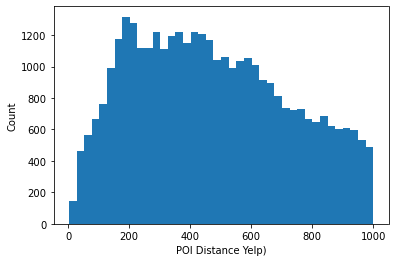

In [23]:
plt.hist(duplicates_resolved_by_station_integrated.POI_Yelp_Distance,bins=40)
plt.xlabel('POI Distance Yelp)')
plt.ylabel('Count')
plt.savefig('../Images/Histogram_POI_Distances_Yelp.jpg')

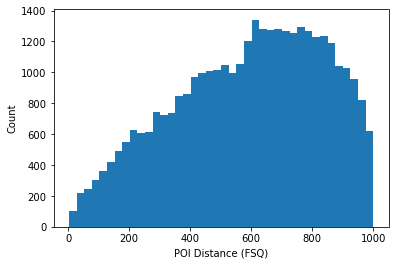

In [27]:
plt.hist(duplicates_resolved_by_station_integrated.POI_FSQ_Distance,bins=40)
plt.xlabel('POI Distance (FSQ)')
plt.ylabel('Count')
plt.savefig('../Images/Histogram_POI_Distances_FSQ.jpg')

## Visualizing the Data

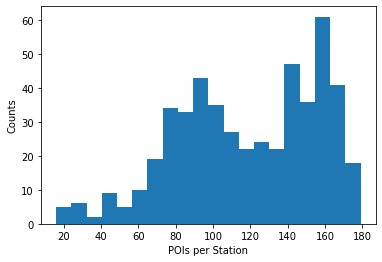

In [28]:
# Let's look at the distribution of POI counts per bike station -- looks oddly bimodal; something to investigate further
counts = duplicates_resolved_by_station.Bike_Station_ID.value_counts()
plot = plt.hist(counts,bins=20)
plt.xlabel('POIs per Station')
plt.ylabel('Counts')
plt.savefig('../Images/POI_Counts_Histogram.jpg',dpi=400)


In [29]:
# Let's see if Yelp and FSQ report around the same number of POIs for the same station

# Get the POI counts for each API
POI_counts_FSQ = duplicates_resolved_by_station_integrated[duplicates_resolved_by_station_integrated.POI_API.isin(['FSQ','Both'])].Bike_Station_ID.value_counts()
POI_counts_yelp = duplicates_resolved_by_station_integrated[duplicates_resolved_by_station_integrated.POI_API.isin(['Yelp','Both'])].Bike_Station_ID.value_counts()

# Concatenate them by row to match 
compare_POI_counts = pd.concat([POI_counts_FSQ,POI_counts_yelp],axis=1)

# Name the columns
compare_POI_counts.columns = ['FSQ','Yelp']

# Take a look at the new data frame
compare_POI_counts

,FSQ,Yelp
453a6d0d-31ce-4204-b2e1-2f9532e4b356,99,94
e4921f52-7a6c-4baa-b057-ddc7051980ca,99,104
759c388e-ab9b-40c2-ae96-ee5190264916,98,96
6d0651c2-022b-4e4d-add0-a1bda32e6725,97,87
08a1a4d2-e83a-4911-8743-41006698f4da,97,96
...,...,...
59cb1eda-68ac-43fd-a05a-9250d7f9ace3,16,11
ea2a009b-6a83-4b81-ba35-c175c492f4f4,16,22
35e3bf9b-4c65-4f2b-9d46-32afe9fe82d9,14,9
c0d7ba8d-145a-40fc-aa06-f4c06fc49edb,11,10


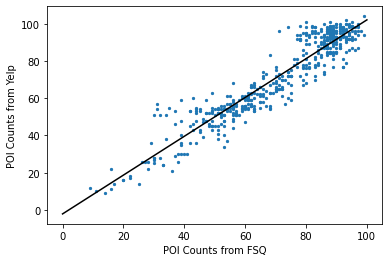

In [30]:
# Do a scatter plot of the two API's POI counts per station -- they are pretty correlated
# R-square of 0.990 indicates most of the variance in the dependent variable is due to the independent variable
# A low p-value of 0 means we can reject the null hypothesis and accept the alternate hypothesis 
plt.scatter(compare_POI_counts.FSQ,compare_POI_counts.Yelp,s=5)
slope, intercept = linregress(compare_POI_counts.FSQ,compare_POI_counts.Yelp)[:2]
xvals = [0,100]
yvals = [ (slope*x)+intercept for x in xvals ]
plt.plot(xvals,yvals,c='black')
plt.xlabel('POI Counts from FSQ')
plt.ylabel('POI Counts from Yelp')
plt.savefig('../Images/Scatter_FSQ_vs_Yelp_POI_Counts.jpg', dpi=400)

There is a high linear correlation between the number of POI returned by Yelp's API and that of Foursquare's.

In [39]:
# t-test to see if ratings between the two APIs are significantly different 
Data_By_Business = pd.read_csv('../FinalData/FinalPOIDataByBusiness.csv')
fsq_ratings = Data_By_Business['POI_FSQ_Bayesian_Adj_Rating_Norm'].dropna()
yelp_ratings = Data_By_Business['POI_Yelp_Bayesian_Adj_Rating_Norm'].dropna()

t, p = stats.ttest_ind(fsq_ratings,yelp_ratings)

if p < 0.05:
    print("The two sets of ratings are significantly different (p=%s)." % p)
else:
    print("The two sets of ratings are not significantly different (p=%s)." % p)

The two sets of ratings are significantly different (p=1.3404045164848164e-44).


In [40]:
model = sm.OLS(compare_POI_counts.FSQ,compare_POI_counts.Yelp)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                    FSQ   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          4.932e+04
Date:                Sun, 29 Jan 2023   Prob (F-statistic):                        0.00
Time:                        01:01:26   Log-Likelihood:                         -1701.4
No. Observations:                 499   AIC:                                      3405.
Df Residuals:                     498   BIC:                                      3409.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

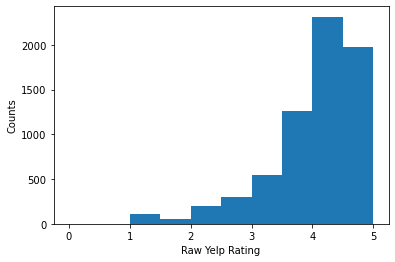

In [42]:
# How are ratings (Bayesian and raw) distributed for both APIs?
plt.hist(duplicates_resolved_regardless_of_station.POI_Yelp_Rating)
plt.xlabel('Raw Yelp Rating')
plt.ylabel('Counts')
plt.savefig('../Images/Histogram_Raw_Yelp_Ratings.jpg', dpi=400)

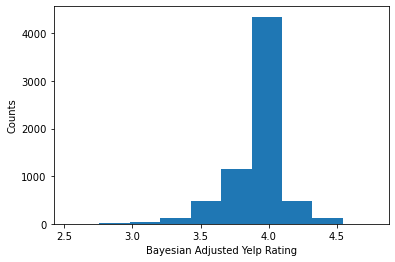

In [43]:
plt.hist(duplicates_resolved_regardless_of_station.POI_Yelp_Bayesian_Adj_Rating)
plt.xlabel('Bayesian Adjusted Yelp Rating')
plt.ylabel('Counts')
plt.savefig('../Images/Histogram_Adjusted_Yelp_Rating.jpg', dpi=400)

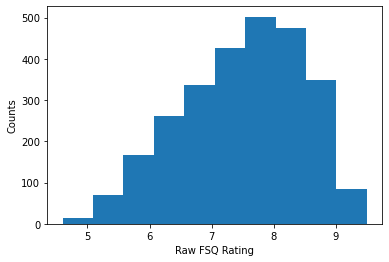

In [44]:
plt.hist(duplicates_resolved_regardless_of_station.POI_FSQ_Rating)
plt.xlabel('Raw FSQ Rating')
plt.ylabel('Counts')
plt.savefig('../Images/Histogram_Raw_FSQ_Rating.jpg', dpi=400)

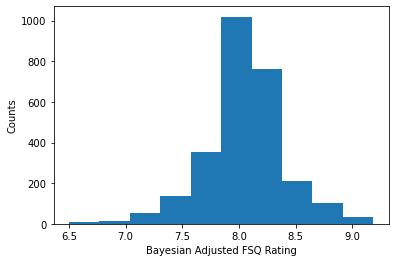

In [45]:
plt.hist(duplicates_resolved_regardless_of_station.POI_FSQ_Bayesian_Adj_Rating)
plt.xlabel('Bayesian Adjusted FSQ Rating')
plt.ylabel('Counts')
plt.savefig('../Images/Histogram_Adjusted_FSQ_Rating.jpg', dpi=400)

Both APIs have raw ratings that are right-shifted, meaning more ratings are good than bad. In both cases, the Bayesian average results in a spike at the system mean, for all ratings based on very few individual rating countsBoth APIs have raw ratings that are right-shifted, meaning more ratings are good than bad.  In both cases, the Bayesian average results in a spike at the system mean, for all ratings based on very few individual rating counts

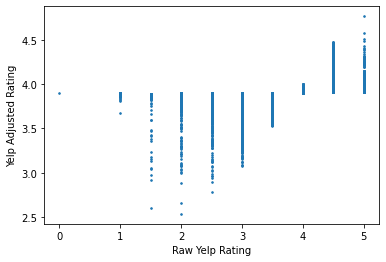

In [46]:
# Let's see how the Bayesian adjusted rating compares to the raw rating for each API; first Yelp:
plt.scatter(duplicates_resolved_regardless_of_station.POI_Yelp_Rating,duplicates_resolved_regardless_of_station.POI_Yelp_Bayesian_Adj_Rating,s=2.5)
plt.xlabel('Raw Yelp Rating')
plt.ylabel('Yelp Adjusted Rating')
plt.savefig('../Images/Scatter_Yelp_Raw_vs_Yelp_Adj.jpg',dpi=400)

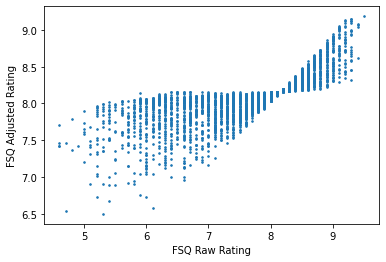

In [47]:
# Now for FSQ:
plt.scatter(duplicates_resolved_regardless_of_station.POI_FSQ_Rating,duplicates_resolved_regardless_of_station.POI_FSQ_Bayesian_Adj_Rating,s=2.5)
plt.xlabel('FSQ Raw Rating')
plt.ylabel('FSQ Adjusted Rating')
plt.savefig('../Images/Scatter_FSQ_Raw_vs_FSQ_Adj.jpg',dpi=400)

In both cases, the overall mean rating is apparent as the inflection point, with raw ratings being drawn to the mean if they have low rating counts; FSQ has finer resolution of its raw ratings

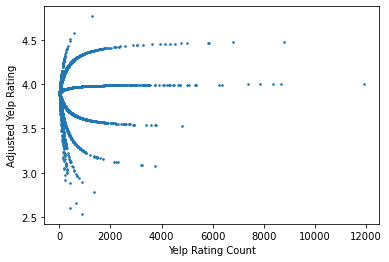

In [48]:
# Let's look at the relationship between Bayesian adjusted rating and rating counts for both APIs, first Yelp:
plt.scatter(duplicates_resolved_regardless_of_station.POI_Yelp_Num_Ratings,duplicates_resolved_regardless_of_station.POI_Yelp_Bayesian_Adj_Rating,s=2.5)
plt.xlabel('Yelp Rating Count')
plt.ylabel('Adjusted Yelp Rating')
plt.savefig('../Images/Scatter_Yelp_Counts_vs_Adj_Rating.jpg',dpi=400)

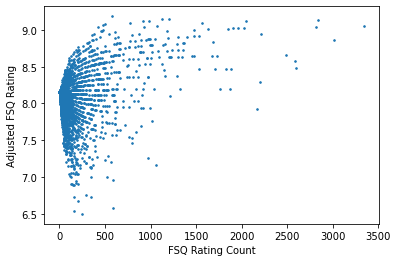

In [49]:
# And for FSQ:
plt.scatter(duplicates_resolved_regardless_of_station.POI_FSQ_Num_Ratings,duplicates_resolved_regardless_of_station.POI_FSQ_Bayesian_Adj_Rating,s=2.5)
plt.xlabel('FSQ Rating Count')
plt.ylabel('Adjusted FSQ Rating')
plt.savefig('../Images/Scatter_FSQ_Counts_vs_Adj_Rating.jpg',dpi=400)

In both cases, the weird looking curved lines are due to both APIs reporting their average ratings to the nearest 0.5 (Yelp) or 0.1 (FSQ) resolution; if they were continuous this wouldn't happen.  But what is apparent is that in both cases, low number of ratings results in convergence on the mean of all ratings, while high number of ratings results in divergence to the arithmetic means

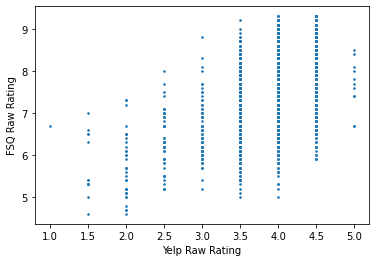

In [50]:
# How related are the ratings correlated for both APIS?  Let's look at raw ratings first
plt.scatter(duplicates_resolved_regardless_of_station.POI_Yelp_Rating,duplicates_resolved_regardless_of_station.POI_FSQ_Rating,s=2.5)
plt.xlabel('Yelp Raw Rating')
plt.ylabel('FSQ Raw Rating')
plt.savefig('../Images/Scatter_Yelp_Raw_vs_FSQ_Raw.jpg',dpi=400)

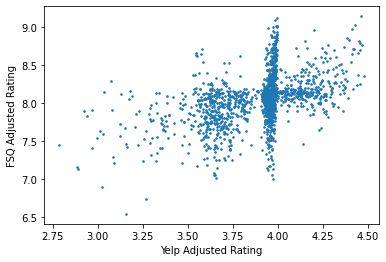

In [51]:
# What about the Bayesian adjusted ratings?
plt.scatter(duplicates_resolved_regardless_of_station.POI_Yelp_Bayesian_Adj_Rating,duplicates_resolved_regardless_of_station.POI_FSQ_Bayesian_Adj_Rating,s=2.5)
plt.xlabel('Yelp Adjusted Rating')
plt.ylabel('FSQ Adjusted Rating')
plt.savefig('../Images/Yelp_Adj_vs_FSQ_Adj.jpg',dpi=400)

So neither the raw ratings nor the Bayesian adjusted ratings show much correlation; looks like just because a business is rated a certain way on one API, doesn't necessarily mean it will be rated similarly by the other

# Step Four:
## Build a regression model using Python’s statsmodels module that demonstrates a relationship between the number of bikes in a particular location and the characteristics of the POIs in that location.


In [52]:
# Let's see if the POI counts per bike station have any relationship to characteristics of the bike station itself, using the same method of getting POI counts as bove

# Get the POI counts for each API
POI_counts_ALL = duplicates_resolved_by_station_integrated.Bike_Station_ID.value_counts()
POI_counts_FSQ = duplicates_resolved_by_station_integrated[duplicates_resolved_by_station_integrated.POI_API.isin(['FSQ','Both'])].Bike_Station_ID.value_counts()
POI_counts_yelp = duplicates_resolved_by_station_integrated[duplicates_resolved_by_station_integrated.POI_API.isin(['Yelp','Both'])].Bike_Station_ID.value_counts()

# Concatenate them by row to match 
compare_POI_counts = pd.concat([POI_counts_ALL,POI_counts_FSQ,POI_counts_yelp],axis=1)

# Name the columns
compare_POI_counts.columns = ['POI_Counts_Both','POI_Counts_FSQ','POI_Counts_Yelp']

# Merge the bike station data
compare_POI_counts = pd.merge(compare_POI_counts,bike_data,left_index=True,right_index=True)

# Inspect the data frame
compare_POI_counts

,POI_Counts_Both,POI_Counts_FSQ,POI_Counts_Yelp,StationID,Latitude,Longitude,BikesAvailable,DocksAvailable,Total_Docks,Station_Occupancy
e4921f52-7a6c-4baa-b057-ddc7051980ca,179,99,104,e4921f52-7a6c-4baa-b057-ddc7051980ca,37.806163,-122.276040,16,4,20,80.0
9e3efff1-3d42-46fd-8206-4021277ba6c2,176,97,100,9e3efff1-3d42-46fd-8206-4021277ba6c2,37.804562,-122.271738,17,18,35,48.6
492edeb7-7c9f-4845-b5cc-442faedb3a56,175,97,98,492edeb7-7c9f-4845-b5cc-442faedb3a56,37.802688,-122.269146,10,9,19,52.6
b48ebe9a-8d7b-4ac1-b0da-db5978404330,175,90,93,b48ebe9a-8d7b-4ac1-b0da-db5978404330,37.784078,-122.411926,1,22,23,4.3
6d0651c2-022b-4e4d-add0-a1bda32e6725,174,97,87,6d0651c2-022b-4e4d-add0-a1bda32e6725,37.788300,-122.408531,1,24,25,4.0
...,...,...,...,...,...,...,...,...,...,...
748ac5c0-bb8c-4a55-9c56-6c91b2e859e1,24,17,14,748ac5c0-bb8c-4a55-9c56-6c91b2e859e1,37.796593,-122.455688,1,17,18,5.6
59cb1eda-68ac-43fd-a05a-9250d7f9ace3,20,16,11,59cb1eda-68ac-43fd-a05a-9250d7f9ace3,37.801750,-122.456363,3,17,20,15.0
7d59176c-49dd-4b07-a5ab-bcc109974db3,18,9,12,7d59176c-49dd-4b07-a5ab-bcc109974db3,37.360001,-121.878778,7,12,19,36.8
35e3bf9b-4c65-4f2b-9d46-32afe9fe82d9,17,14,9,35e3bf9b-4c65-4f2b-9d46-32afe9fe82d9,37.803968,-122.455079,1,15,16,6.2


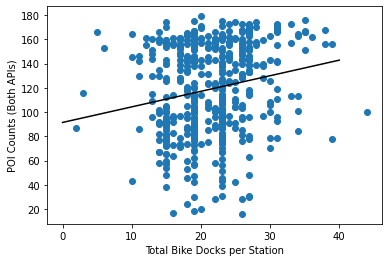

In [53]:
# Let's see if size (total docks) is related to number of nearby POIs -- doesn't seem to be
plt.scatter(compare_POI_counts.Total_Docks,compare_POI_counts.POI_Counts_Both)
slope, intercept = linregress(compare_POI_counts.Total_Docks,compare_POI_counts.POI_Counts_Both)[:2]
xvals = [0,40]
yvals = [ (slope*x)+intercept for x in xvals ]
plt.plot(xvals,yvals,c='black')
plt.xlabel('Total Bike Docks per Station')
plt.ylabel('POI Counts (Both APIs)')
plt.savefig('../Images/Scatter_Bike_Docks_vs_POIs_Both.jpg',dpi=400)

In [54]:
model = sm.OLS(compare_POI_counts.Total_Docks,compare_POI_counts.POI_Counts_Both)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Total_Docks   R-squared (uncentered):                   0.877
Model:                            OLS   Adj. R-squared (uncentered):              0.877
Method:                 Least Squares   F-statistic:                              3543.
Date:                Sun, 29 Jan 2023   Prob (F-statistic):                   1.51e-228
Time:                        01:01:58   Log-Likelihood:                         -1730.3
No. Observations:                 499   AIC:                                      3463.
Df Residuals:                     498   BIC:                                      3467.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

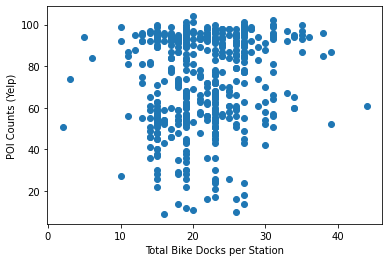

In [55]:
# There also doesn't appear to be a correlation between number of POI from Yelp and total docks 
plt.scatter(compare_POI_counts.Total_Docks,compare_POI_counts.POI_Counts_Yelp)
plt.xlabel('Total Bike Docks per Station')
plt.ylabel('POI Counts (Yelp)')
plt.savefig('../Images/Scatter_Bike_Docks_vs_POIs_Yelp.jpg',dpi=400)

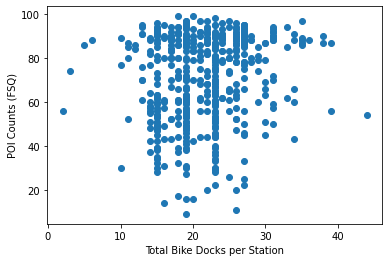

In [56]:
# There also doesn't appear to be a correlation between number of POI from Foursquare and total docks 
plt.scatter(compare_POI_counts.Total_Docks,compare_POI_counts.POI_Counts_FSQ)
plt.xlabel('Total Bike Docks per Station')
plt.ylabel('POI Counts (FSQ)')
plt.savefig('../Images/Scatter_Bike_Docks_vs_POIs_FSQ.jpg',dpi=400)

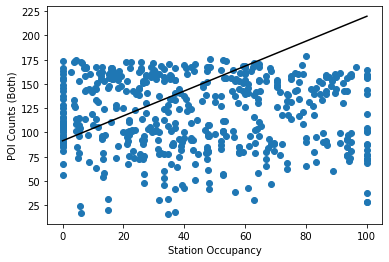

In [60]:
# Let's see if bike station occupancy (percent of total bikes that are available) is related to POI counts -- doesn't seem to be
plt.scatter(compare_POI_counts.Station_Occupancy,compare_POI_counts.POI_Counts_Both)
slope, intercept = linregress(compare_POI_counts.Total_Docks,compare_POI_counts.POI_Counts_Both)[:2]
xvals = [0,100]
yvals = [ (slope*x)+intercept for x in xvals ]
plt.plot(xvals,yvals,c='black')
plt.xlabel('Station Occupancy')
plt.ylabel('POI Counts (Both)')
plt.savefig('../Images/Scatter_Station_Occupancy_vs_POIs_Both.jpg',dpi=400)

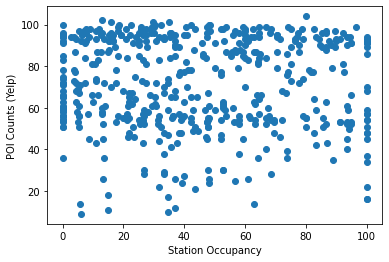

In [61]:
# There also doesn't appear to be a correlation between number of POI from Yelp and station occupancy (# bikes still at the station)
# ie. more POI near a station doesn't necessarily mean less bikes are available
# This could indicate effectiveness in having bikes available at stations where bikes have a higher rate of being taken out
# Maybe also effectiveness in having bikes taken from less busy stations to feed into busier stations 
plt.scatter(compare_POI_counts.Station_Occupancy,compare_POI_counts.POI_Counts_Yelp)
plt.xlabel('Station Occupancy')
plt.ylabel('POI Counts (Yelp)')
plt.savefig('../Images/Scatter_Station_Occupancy_vs_POIs_Yelp.jpg',dpi=400)

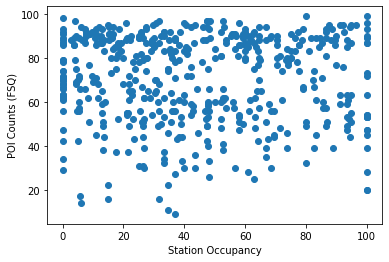

In [62]:
# There also doesn't appear to be a correlation between number of POI from FSQ and station occupancy (# bikes still at the station)
plt.scatter(compare_POI_counts.Station_Occupancy,compare_POI_counts.POI_Counts_FSQ)
plt.xlabel('Station Occupancy')
plt.ylabel('POI Counts (FSQ)')
plt.savefig('../Images/Scatter_Station_Occupancy_vs_POIs_FSQ.jpg',dpi=400)

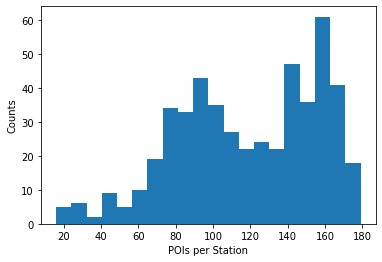

In [63]:
# Let's see what might be responsible for that bimodal distribution of POI counts per station; to review:
counts = duplicates_resolved_by_station.Bike_Station_ID.value_counts()
plt.hist(counts,bins=20)
plt.xlabel('POIs per Station')
plt.ylabel('Counts')
plt.savefig('../Images/POI_Counts_Histogram.jpg',dpi=400)

In [64]:
# There seem to be a large number of stations with around 160 POIs, and a large number with around 90 POIs

# Hypothesis: These represent stations clustered in different areas with a lot of overlapping POIs between them

# So let's extraction the coordinates for stations with POI counts in these peaks
cluster1 = counts[(counts >= 85) & (counts <= 95)]
cluster2 = counts[(counts >= 150) & (counts <= 160)]

# Retrieve the bike station info for the station IDs in each cluster
cluster1 = bike_data.loc[cluster1.index]
cluster2 = bike_data.loc[cluster2.index]

# Write them both to CSV; the coordinates can be plotted externally with online tools (www.gpsvisualizer.com)
cluster1.to_csv('../FinalData/POI_Count_Cluster1.csv',index=False)
cluster2.to_csv('../FinalData/POI_Count_Cluster2.csv',index=False)

In [65]:
# What about the stations with the fewest POIs?
low_POIs = counts[counts < 70]

# Retrieve bike data
low_POIs = bike_data.loc[low_POIs.index]

# Save it
low_POIs.to_csv('../FinalData/POI_Count_Low.csv',index=False)

In [66]:
# Let's merge POI counts and the coordinate data to plot it all with POI used for marker color, on an external site (www.gpsvisualizer.com)
counts.name='POI_Counts'
counts_and_coordinates = pd.merge(counts,bike_data,left_index=True,right_index=True)[['Latitude','Longitude','POI_Counts']]
counts_and_coordinates.to_csv('../FinalData/CountsAndCoordinates.csv')

## How can you turn the regression model into a classification model?

The dependent variable can be a 'zone', where different zones are geographic areas of a city where there is a high number of POI within 1000m from a given point. 
I'd create a multinomial regression models for multinomial classification, which is used to model outputs that can take two or more values.